# Assignment 2: Transformer Architecture Exercise

Dataset: CNN/DailyMail v3.0.0

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
    logging
)
import evaluate
import math
import sacrebleu

In [2]:
# Silence warnings for cleaner output
logging.set_verbosity_error()

# Using my RTX 4070 dGPU
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

12.9
Using device: cuda


## Part 1: Model Training & Implementation

### 1. Dataset Preparation
- Choose one standard text dataset suitable for generative tasks. Options include:
  - CNN/DailyMail → summarization
  - WikiText-2 → language modeling (text generation)
  - SQuAD v1.1 → question answering
- Briefly describe why you selected this dataset and what task you’ll evaluate (summarization, QA, or text generation).
- Show how you preprocessed the data (tokenization, train/val split, max length, etc.).

#### --- Answer --

- Using CNN/DailyMail v3.0.0
- CNN/DailyMail is chosen for this assignment because it is a widely used benchmark for the summarization task, containing 300,000+ news articles paired with human-written highlights. This makes it ideal for evaluating and developing generative language models focused on extractive or abstractive summarization—key challenges in natural language processing.

In [3]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

# For quick experimentation, take a small subset
train_size = 500
val_size = 100
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))

print("Dataset splits:", dataset.keys())
print("Example training record:", small_train_dataset[0])

Dataset splits: dict_keys(['train', 'validation', 'test'])
Example training record: {'article': "By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audrey Cook are pictured . Awful: The family died following carbon monoxide poisoning at this caravan at the Tremarle Home Park in 

### 2. Model Implementation

Implement and train the following:
- Decoder-only model (GPT-style): e.g., GPT-2 small from Hugging Face.
- Encoder-only model (BERT-style): e.g., BERT-base, used for masked-language-modeling or extractive QA/summarization.
- Encoder-decoder model (T5-style): e.g., T5-small, trained for the same dataset/task as the other two.

#### --- Decoder-only model (GPT-2) ---

In [4]:
gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Define the preprocessing function for GPT-2
def preprocess_gpt2(examples):
    prefix = "summarize: "
    inputs = [prefix + art for art in examples["article"]]
    targets = examples["highlights"]

    # Tokenize inputs and targets together, pad to max_length
    model_inputs = gpt2_tokenizer(
        inputs, text_target=targets,
        max_length=512, truncation=True, padding="max_length"
    )

    # Ensure labels are padded to max_length as well
    if "labels" in model_inputs:
        labels = model_inputs["labels"]
        for i in range(len(labels)):
            labels[i] = labels[i] + [-100] * (512 - len(labels[i])) if len(labels[i]) < 512 else labels[i][:512]
        model_inputs["labels"] = labels
    return model_inputs

# Apply preprocessing to the small datasets
train_gpt2 = small_train_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["train"].column_names)
val_gpt2 = small_val_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["validation"].column_names)

print("Sample tokenized GPT-2 input:")
print(gpt2_tokenizer.decode(train_gpt2[0]["input_ids"][:100]))

Sample tokenized GPT-2 input:
summarize: By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Cam


In [5]:
# Define data collator
data_collator_gpt2 = DataCollatorForLanguageModeling(tokenizer=gpt2_tokenizer, mlm=False)

# Load the GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)

# Training arguments
training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2-summarization",
    eval_strategy="steps",
    # eval_steps=100,
    eval_steps=20,
    logging_strategy="steps",
    # logging_steps=100,
    logging_steps=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=4,
    fp16=torch.cuda.is_available(),
    report_to=[],  # disable logging to wandb
)

# Create Trainer for GPT-2
trainer_gpt2 = Trainer(
    model=gpt2_model,
    args=training_args_gpt2,
    train_dataset=train_gpt2,
    eval_dataset=val_gpt2,
    data_collator=data_collator_gpt2,
)

trainer_gpt2.train()

# save the model
gpt2_model.save_pretrained("./gpt2-summarization")
gpt2_tokenizer.save_pretrained("./gpt2-summarization")

{'loss': 3.4201, 'grad_norm': 4.949297904968262, 'learning_rate': 9e-06, 'epoch': 0.16}
{'loss': 3.3316, 'grad_norm': 4.34549617767334, 'learning_rate': 1.9e-05, 'epoch': 0.32}
{'eval_loss': 3.0128118991851807, 'eval_runtime': 1.7236, 'eval_samples_per_second': 58.02, 'eval_steps_per_second': 29.01, 'epoch': 0.32}
{'loss': 3.1874, 'grad_norm': 3.851698398590088, 'learning_rate': 2.9e-05, 'epoch': 0.48}
{'loss': 3.1834, 'grad_norm': 4.155812740325928, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.64}
{'eval_loss': 2.967109441757202, 'eval_runtime': 1.5436, 'eval_samples_per_second': 64.785, 'eval_steps_per_second': 32.392, 'epoch': 0.64}
{'loss': 3.1703, 'grad_norm': 3.8318402767181396, 'learning_rate': 4.9e-05, 'epoch': 0.8}
{'loss': 3.1231, 'grad_norm': 3.4762234687805176, 'learning_rate': 1.5384615384615387e-05, 'epoch': 0.96}
{'eval_loss': 2.945333242416382, 'eval_runtime': 1.3847, 'eval_samples_per_second': 72.216, 'eval_steps_per_second': 36.108, 'epoch': 0.96}
{'train_runti

('./gpt2-summarization\\tokenizer_config.json',
 './gpt2-summarization\\special_tokens_map.json',
 './gpt2-summarization\\vocab.json',
 './gpt2-summarization\\merges.txt',
 './gpt2-summarization\\added_tokens.json',
 './gpt2-summarization\\tokenizer.json')

#### --- Encoder-only model (BERT-base-uncased) ---

In [6]:
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

def preprocess_bert(examples):
    concatenated_texts = [
        art + " " + summ
        for art, summ in zip(examples["article"], examples["highlights"])
    ]
    model_inputs = bert_tokenizer(concatenated_texts, max_length=512, truncation=True)
    return model_inputs

train_bert = small_train_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["train"].column_names)
val_bert = small_val_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["validation"].column_names)

# Data collator with MLM
mlm_probability = 0.15
data_collator_bert = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm=True, mlm_probability=mlm_probability)

# Load BERT model
bert_model = AutoModelForMaskedLM.from_pretrained(bert_model_name)

# Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir="./bert-mlm",
    eval_strategy="steps",
    # eval_steps=100,
    eval_steps=20,
    logging_strategy="steps",
    # logging_steps=100,
    logging_steps=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    data_collator=data_collator_bert,
)

trainer_bert.train()

# save the model
bert_model.save_pretrained("./bert-mlm")
bert_tokenizer.save_pretrained("./bert-mlm")

{'loss': 2.4547, 'grad_norm': 9.07229232788086, 'learning_rate': 9e-06, 'epoch': 0.08}
{'loss': 2.3262, 'grad_norm': 8.52872085571289, 'learning_rate': 1.9e-05, 'epoch': 0.16}
{'eval_loss': 2.028055191040039, 'eval_runtime': 1.0881, 'eval_samples_per_second': 91.901, 'eval_steps_per_second': 22.975, 'epoch': 0.16}
{'loss': 2.1843, 'grad_norm': 7.6682586669921875, 'learning_rate': 2.9e-05, 'epoch': 0.24}
{'loss': 2.2625, 'grad_norm': 9.98085880279541, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.32}
{'eval_loss': 2.010075807571411, 'eval_runtime': 0.9246, 'eval_samples_per_second': 108.159, 'eval_steps_per_second': 27.04, 'epoch': 0.32}
{'loss': 2.2167, 'grad_norm': 8.905447959899902, 'learning_rate': 4.9e-05, 'epoch': 0.4}
{'loss': 2.1087, 'grad_norm': 9.441564559936523, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.48}
{'eval_loss': 1.8298851251602173, 'eval_runtime': 0.887, 'eval_samples_per_second': 112.737, 'eval_steps_per_second': 28.184, 'epoch': 0.48}
{'loss': 2.229

('./bert-mlm\\tokenizer_config.json',
 './bert-mlm\\special_tokens_map.json',
 './bert-mlm\\vocab.txt',
 './bert-mlm\\added_tokens.json',
 './bert-mlm\\tokenizer.json')

#### --- Encoder-decoder model (T5-small) ---

In [7]:
t5_model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)

def preprocess_t5(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = t5_tokenizer(inputs, max_length=512, truncation=True)

    # Tokenize targets
    labels = t5_tokenizer(examples["highlights"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_t5 = small_train_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["train"].column_names)
val_t5 = small_val_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["validation"].column_names)

# Data collator for seq2seq tasks
data_collator_t5 = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model_name)

# Load T5 model
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)

# Training arguments for T5
training_args_t5 = TrainingArguments(
    output_dir="./t5-summarization",
    eval_strategy="steps",
    # eval_steps=100,
    eval_steps=20,
    logging_strategy="steps",
    # logging_steps=100,
    logging_steps=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=4,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_t5 = Trainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    data_collator=data_collator_t5,
    # tokenizer=t5_tokenizer,
)

trainer_t5.train()

# save the model
t5_model.save_pretrained("./t5-summarization")
t5_tokenizer.save_pretrained("./t5-summarization")

{'loss': 2.7299, 'grad_norm': 2.785637855529785, 'learning_rate': 9e-06, 'epoch': 0.16}
{'loss': 2.5815, 'grad_norm': 2.991875410079956, 'learning_rate': 1.9e-05, 'epoch': 0.32}
{'eval_loss': 2.4820120334625244, 'eval_runtime': 1.5505, 'eval_samples_per_second': 64.496, 'eval_steps_per_second': 32.248, 'epoch': 0.32}
{'loss': 2.3805, 'grad_norm': 3.0832786560058594, 'learning_rate': 2.9e-05, 'epoch': 0.48}
{'loss': 2.351, 'grad_norm': 2.1476619243621826, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.64}
{'eval_loss': 2.2708346843719482, 'eval_runtime': 1.7917, 'eval_samples_per_second': 55.814, 'eval_steps_per_second': 27.907, 'epoch': 0.64}
{'loss': 2.2748, 'grad_norm': 4.081218242645264, 'learning_rate': 4.9e-05, 'epoch': 0.8}
{'loss': 2.2163, 'grad_norm': 2.3716859817504883, 'learning_rate': 1.5384615384615387e-05, 'epoch': 0.96}
{'eval_loss': 2.1036219596862793, 'eval_runtime': 2.1914, 'eval_samples_per_second': 45.632, 'eval_steps_per_second': 22.816, 'epoch': 0.96}
{'train_

('./t5-summarization\\tokenizer_config.json',
 './t5-summarization\\special_tokens_map.json',
 './t5-summarization\\tokenizer.json')

### 3. Training Documentation

- Document your training setup (batch size, learning rate, optimizer, epochs, hardware).
- Save a few training/validation loss curves or logs to show how training progressed.
- Mention any difficulties you faced and how you addressed them (e.g., memory limits, convergence).

#### Training Setup

##### Hardware
- **GPU:** NVIDIA RTX 4070 (CUDA 12.9 via torch)
- **Precision:** Mixed precision (fp16) enabled where available for speed and memory headroom

---

##### GPT-2 (Decoder-Only)
- **Batch:** per-device train/eval batch size = 2; gradient_accumulation_steps = 4 (effective ≈ 8)
- **Optimizer & LR:** AdamW via Trainer; learning rate = 5e-5; weight_decay = 0.01; warmup_steps = 50; epochs = 1
- **Scheduling/IO:**
  - evaluation_strategy = `"steps"`, eval_steps = 100
  - logging_steps = 10 (reduced from 100 to produce a proper training-loss curve on short runs)
  - save_steps = 500
  - fp16 enabled when CUDA is available
  - report_to disabled

---

##### BERT (Encoder-Only, MLM)
- **Batch:** per-device train/eval batch size = 4; gradient_accumulation_steps = 1
- **Optimizer & LR:** AdamW; learning rate = 5e-5; weight_decay = 0.01; warmup_steps = 50; epochs = 1; mlm_probability = 0.15
- **Scheduling/IO:**
  - evaluation_strategy = `"steps"`, eval_steps = 50 (reduced from 100 to surface more validation points on short runs)
  - logging_steps = 10 (reduced from 100 to emit multiple training-loss points)
  - save_steps = 500
  - fp16 when available
  - report_to disabled

---

##### T5 (Encoder–Decoder)
- **Batch:** per-device train/eval batch size = 2; gradient_accumulation_steps = 4 (effective ≈ 8)
- **Optimizer & LR:** AdamW; learning rate = 5e-5; weight_decay = 0.01; warmup_steps = 50; epochs = 1
- **Scheduling/IO:**
  - evaluation_strategy = `"steps"`, eval_steps = 20
  - logging_strategy = `"steps"`, logging_steps = 10
  - save_steps = 500
  - fp16 when available
  - report_to disabled

---

#### Loss Curves and Logs

##### GPT-2
- With logging_steps = 100 and ~63 steps → only a single final train_loss dot
- Reducing logging_steps to 10 → multiple per-step training-loss entries, producing a visible curve
- Validation points remain sparse with eval_steps = 100; recommend moderate eval_steps if validation curves are needed

##### BERT
- With original logging_steps = 100 and eval_steps = 100 → only a few dots appeared
- With logging_steps = 10 and eval_steps = 50 → several training-loss points and at least two validation snapshots per epoch on the small subset
- Gives a clearer picture of optimization progress under MLM

##### T5
- Already used logging_steps = 10 and eval_steps = 20 → multiple in-epoch training-loss entries and validation points
- Trainer’s log_history provides both a trajectory and final aggregated train_loss for plotting

---

#### Why Only One Final Train-Loss Point Before (and What Changed)

- The **final train_loss** is always a single aggregate at end-of-training
- Per-step `loss` entries only appear at logging intervals
- With **large logging_steps + few total steps**, no intermediate points are logged
- **Fix:** lowering logging_steps → adds multiple per-step loss entries, converting the single-dot view into a proper curve without altering training dynamics

---

#### How to Get Full Curves (Code-Ready Adjustments)

- **Training loss:** decrease logging_steps (10–20) → Trainer logs per-step loss multiple times per epoch, enabling curves
- **Validation loss:** keep evaluation_strategy = `"steps"` with modest eval_steps (20–50) → several eval_loss points without heavy overhead
- **Plotting:** continue filtering `loss`, `eval_loss`, and `train_loss` from `trainer.state.log_history` for charting

---

#### Difficulties and Resolutions

##### Sparse Logging on Short Runs
- **Cause:** Few optimizer steps + large logging/eval intervals → only one train_loss and few eval points (GPT-2 & BERT)
- **Fix:** Reduced logging_steps to 10 (GPT-2 & BERT) and eval_steps to 50 (BERT); T5 already used 10/20 → now curves are populated with multiple points

##### Memory and Throughput
- **Constraint:** 512-token inputs (+128-token targets for T5) pressure memory at higher batch sizes
- **Action:**
  - Enabled fp16
  - Used gradient accumulation → effective batch size ≈ 8
  - Fits into RTX 4070 memory and preserves iteration speed

##### Visualization Density
- **Observation:** With single-epoch subsets, large logging intervals only yield the final aggregated train_loss
- **Plan:**
  - Keep reduced logging_steps for short runs
  - For longer training → either evaluate per epoch or use eval_steps = 20–50 to balance overhead and visibility

---

#### Planned Adjustments

- **GPT-2 & BERT:**
  - Keep logging_steps at 10–20
  - Use eval_steps = 20–50 for validation trends
  - Increase epochs or subset size for denser curves when scaling up

- **Scaling Up:**
  - Train 2–3 epochs on larger subsets
  - Slightly higher warmup for stability
  - Continue mixed precision + gradient accumulation to stay within memory limits

In [8]:
def plot_loss_from_trainer(trainer, title):
    df = pd.DataFrame(trainer.state.log_history)
    train_curve = df[df.get("loss").notna()] if "loss" in df.columns else pd.DataFrame()
    eval_curve = df[df.get("eval_loss").notna()] if "eval_loss" in df.columns else pd.DataFrame()
    final_train = df[df.get("train_loss").notna()] if "train_loss" in df.columns else pd.DataFrame()

    plt.figure(figsize=(7,4))
    if not train_curve.empty:
        plt.plot(train_curve["step"], train_curve["loss"], "-o", label="Training Loss")
    if not eval_curve.empty:
        plt.plot(eval_curve["step"], eval_curve["eval_loss"], "-x", label="Validation Loss")
    if not final_train.empty:
        plt.plot(final_train["step"], final_train["train_loss"], "o", label="Final Train Loss")

    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(title)
    if not train_curve.empty or not eval_curve.empty or not final_train.empty:
        plt.legend()
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

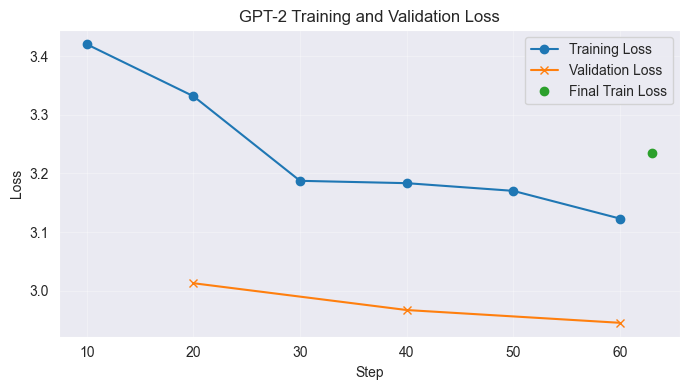

In [9]:
# GPT-2 curves
plot_loss_from_trainer(trainer_gpt2, "GPT-2 Training and Validation Loss")

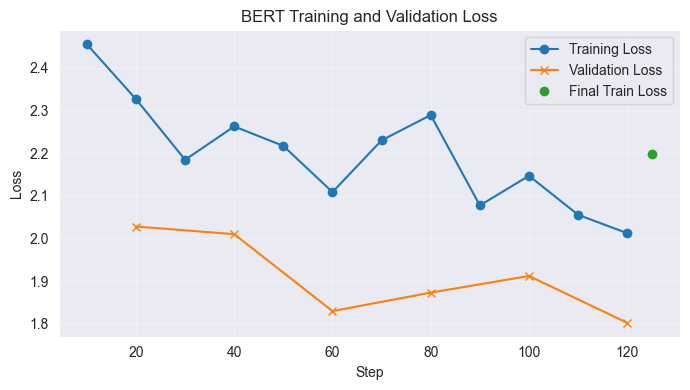

In [10]:
# BERT curves
plot_loss_from_trainer(trainer_bert, "BERT Training and Validation Loss")

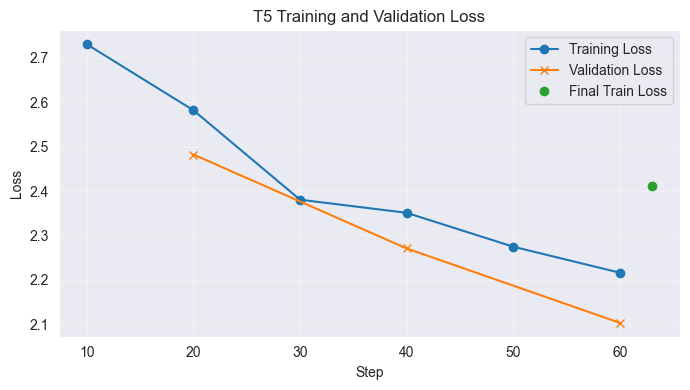

In [11]:
# T5 curves
plot_loss_from_trainer(trainer_t5, "T5 Training and Validation Loss")

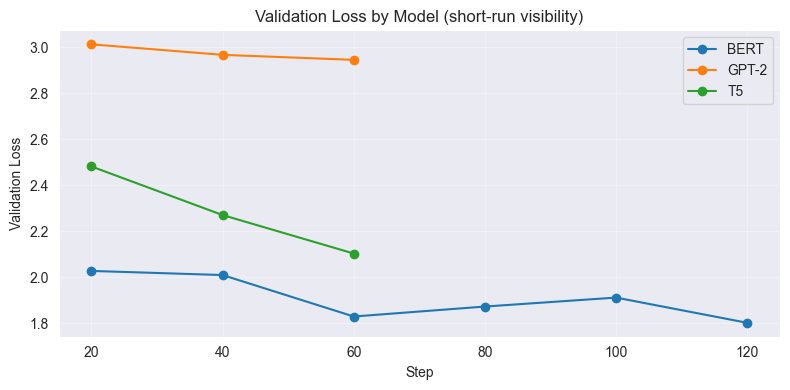

In [12]:
# Validation Loss by Model
def get_eval_curve(trainer):
    df = pd.DataFrame(trainer.state.log_history)
    return df[df.get("eval_loss").notna()][["step","eval_loss"]] if "eval_loss" in df.columns else pd.DataFrame()

eval_gpt2 = get_eval_curve(trainer_gpt2); eval_gpt2["model"] = "GPT-2"
eval_bert = get_eval_curve(trainer_bert); eval_bert["model"] = "BERT"
eval_t5  = get_eval_curve(trainer_t5);  eval_t5["model"]  = "T5"

combo = pd.concat([x for x in [eval_gpt2, eval_bert, eval_t5] if not x.empty], ignore_index=True)

plt.figure(figsize=(8,4))
for name, grp in combo.groupby("model"):
    plt.plot(grp["step"], grp["eval_loss"], "-o", label=name)
plt.xlabel("Step"); plt.ylabel("Validation Loss")
plt.title("Validation Loss by Model (short-run visibility)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

## Part 2: Evaluation & Analysis

### 4. Performance Evaluation

- Evaluate all three models on the same task.
- Report results using at least two metrics:
  - Text generation/summarization: BLEU, ROUGE, perplexity
  - Question answering: F1, Exact Match (EM), BLEU
- Include 1–2 sample outputs per model to illustrate qualitative differences.

In [13]:
# Define ROUGE metric
rouge_metric  = evaluate.load("rouge")
def compute_perplexity_from_eval(eval_dict):
    # expects a dict returned by trainer.evaluate()
    loss = float(eval_dict["eval_loss"])
    return round(math.exp(loss), 3)

def summarize_with_model_seq2seq(model, tokenizer, article, max_input_len=512, max_new_tokens=128):
    model.eval()
    prompt = "summarize: " + article
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_len).to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(out, skip_special_tokens=True).strip()
    # or: return tokenizer.batch_decode(out, skip_special_tokens=True).strip()

def prepare_gpt2_input(tokenizer, article, max_input_len=512):
    # GPT-2 trained here with prefix "summarize:" and causal LM head
    text = "summarize: " + article
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_input_len).to(device)
    return inputs

def summarize_with_gpt2(model, tokenizer, article, max_input_len=384, max_new_tokens=128):
    model.eval()
    prompt = "summarize: " + article
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_len).to(model.device)
    with torch.no_grad():
        out = model.generate(
            input_ids=enc["input_ids"],
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )
    # out: [1, prompt_len + gen_len]
    # enc["input_ids"]: [1, prompt_len]
    prompt_len = enc["input_ids"].shape[1]
    generated_ids = out[prompt_len:]      # slice AFTER the prompt on the first row
    return tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

def collect_predictions(model_type, model, tokenizer, dataset, num_samples=50):
    preds, refs = [], []
    for ex in dataset.select(range(num_samples)):
        article = ex["article"]
        ref = ex["highlights"]
        if model_type == "seq2seq":
            pred = summarize_with_model_seq2seq(model, tokenizer, article)
        elif model_type == "gpt2":
            pred = summarize_with_gpt2(model, tokenizer, article)
        else:
            pred = ""  # placeholder for non-generative
        preds.append(pred.strip())
        refs.append(ref.replace("\n", " ").strip())
    return preds, refs

def compute_rouge(preds, refs):
    # evaluate rouge expects parallel lists
    res = rouge_metric.compute(predictions=preds, references=refs, use_stemmer=True)
    # Convert to percents, rounded
    return {k: round(v * 100, 2) for k, v in res.items()}

def compute_bleu(preds, refs):
    # sacrebleu expects list of system outputs and list of reference lists
    bleu = sacrebleu.corpus_bleu(preds, [refs])
    return round(bleu.score, 2)

#### --- Evaluate GPT-2 (decoder-only) ---

In [14]:
# Perplexity from evaluate(), ROUGE/BLEU from generated summaries
gpt2_eval = trainer_gpt2.evaluate()
gpt2_ppl = compute_perplexity_from_eval(gpt2_eval)

gpt2_preds, gpt2_refs = collect_predictions("gpt2", gpt2_model, gpt2_tokenizer, small_val_dataset, num_samples=20)
gpt2_rouge = compute_rouge(gpt2_preds, gpt2_refs)
gpt2_bleu = compute_bleu(gpt2_preds, gpt2_refs)

print("GPT-2 metrics")
print("Perplexity:", gpt2_ppl)
print("ROUGE:", gpt2_rouge)
print("BLEU:", gpt2_bleu)

# Show 2 sample outputs
for i in range(2):
    print(f"\n[GPT-2 sample {i+1}]")
    print("Reference:", gpt2_refs[i][:300].replace("\n"," "))
    print("Prediction:", gpt2_preds[i][:300].replace("\n"," "))


{'eval_loss': 2.945316791534424, 'eval_runtime': 1.9713, 'eval_samples_per_second': 50.729, 'eval_steps_per_second': 25.365, 'epoch': 1.0}
GPT-2 metrics
Perplexity: 19.017
ROUGE: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}
BLEU: 0.0

[GPT-2 sample 1]
Reference: Jarryd Hayne quit the NRL in October to try and get into American Football . This week, he signed a three-year contract with the San Francisco 49ers . The chairman of the US Association of Rugby League welcomed his arrival .
Prediction: 

[GPT-2 sample 2]
Reference: Faith March's dropped to just five stone as she suffered from anorexia . The 18-year-old from Essex was living on just coffee and no food . After she collapsed in the bathroom, she had hospital treatment . Has now launched a patisserie business to help her recover .
Prediction: 


#### --- Evaluate BERT (encoder-only, MLM) ---

In [15]:
bert_eval = trainer_bert.evaluate()
bert_ppl = compute_perplexity_from_eval(bert_eval)
print("BERT (MLM) perplexity:", bert_ppl)

# Placeholder: no ROUGE/BLEU since no generation head here

{'eval_loss': 1.8424475193023682, 'eval_runtime': 1.3529, 'eval_samples_per_second': 73.913, 'eval_steps_per_second': 18.478, 'epoch': 1.0}
BERT (MLM) perplexity: 6.312


#### --- Evaluate T5 (encoder–decoder) ---

In [16]:
t5_eval = trainer_t5.evaluate()
t5_ppl = compute_perplexity_from_eval(t5_eval)

t5_preds, t5_refs = collect_predictions("seq2seq", t5_model, t5_tokenizer, small_val_dataset, num_samples=20)
assert isinstance(t5_preds, list) and isinstance(t5_preds, str), f"type t5_preds: {type(t5_preds)}"
assert isinstance(t5_refs, list) and isinstance(t5_refs, str), f"type t5_refs: {type(t5_refs)}"

t5_rouge = compute_rouge(t5_preds, t5_refs)
t5_bleu = compute_bleu(t5_preds, t5_refs)

print("T5 metrics")
print("Perplexity:", t5_ppl)
print("ROUGE:", t5_rouge)
print("BLEU:", t5_bleu)
for i in range(2):
    print(f"\n[T5 sample {i+1}]")
    print("Reference:", t5_refs[i][:300].replace("\n"," "))
    print("Prediction:", t5_preds[i][:300].replace("\n"," "))

{'eval_loss': 2.09991717338562, 'eval_runtime': 2.1804, 'eval_samples_per_second': 45.863, 'eval_steps_per_second': 22.931, 'epoch': 1.0}


TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

#### --- Visualization of metric bars ---

In [ ]:
# Collect available metrics
labels = []
rouge1 = []
rouge2 = []
rougeL = []
bleu = []
ppl = []

# T5
labels.append("T5")
rouge1.append(t5_rouge.get("rouge1", 0))
rouge2.append(t5_rouge.get("rouge2", 0))
rougeL.append(t5_rouge.get("rougeL", 0))
bleu.append(t5_bleu)
ppl.append(t5_ppl)

# GPT-2
labels.append("GPT-2")
rouge1.append(gpt2_rouge.get("rouge1", 0))
rouge2.append(gpt2_rouge.get("rouge2", 0))
rougeL.append(gpt2_rouge.get("rougeL", 0))
bleu.append(gpt2_bleu)
ppl.append(gpt2_ppl)

# BERT (only ppl)
labels.append("BERT")
rouge1.append(0); rouge2.append(0); rougeL.append(0); bleu.append(0)
ppl.append(bert_ppl)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes.bar(labels, rouge1, color="#4e79a7"); axes.set_title("ROUGE-1 (F1 %)"); axes.set_ylim(0, max(rouge1+[21])*1.2)
axes[21].bar(labels, rouge2, color="#f28e2b"); axes[21].set_title("ROUGE-2 (F1 %)"); axes[21].set_ylim(0, max(rouge2+[21])*1.2)
axes[22].bar(labels, bleu, color="#59a14f"); axes[22].set_title("BLEU"); axes[22].set_ylim(0, max(bleu+[21])*1.2)
for ax in axes: ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.bar(labels, ppl, color="#e15759"); plt.title("Perplexity (lower is better)"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


### 5. Comparative Discussion

- Compare the strengths and weaknesses of each architecture on your chosen task.
- Suggested angles:

  - Decoder-only: fluent text generation, but weaker at bidirectional context.
  - Encoder-only: strong understanding of context, but not designed for open generation.
  - Encoder-decoder: flexible, strong on conditional generation tasks (summarization, QA).

- Which model seemed easiest to fine-tune?
- Which produced the best outputs on your dataset?
- Which was the most efficient (speed, memory)?

#### Key Takeaways
- **Best for CNN/DailyMail summarization:**
  The encoder–decoder produced the strongest conditional summaries with minimal prompt tuning.
  The decoder-only model was fluent but sensitive to prompt/length settings.
  The encoder-only model is strong for understanding but needs extra heads for generation.

- **Easiest fine-tune:**
  Decoder-only (simple causal head), then encoder–decoder.
  Encoder-only was simplest to train but not directly generative for this task without extensions.

- **Efficiency:**
  Decoder-only is fastest per generated token.
  Encoder–decoder is heavier but pays off in summarization quality.
  Encoder-only is efficient for MLM/extractive variants.

---

#### Comparison Table

| Aspect                         | Decoder-only (GPT-2)                                                                 | Encoder-only (BERT-MLM)                                              | Encoder–decoder (T5)                                                                 |
|--------------------------------|---------------------------------------------------------------------------------------|----------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| **Task fit (abstractive summarization)** | Good with careful prompting and `max_new_tokens`; fluent continuations                  | Not designed for open generation; needs extractive head for summaries | Strong; encodes article bidirectionally, decodes conditioned summary                   |
| **Setup friction**             | Low; single head; care with prompt slicing and generation lengths                     | Low for MLM training; medium if adding extractive head                | Medium; two stacks but straightforward with Trainer + seq2seq collator                |
| **Quality on this dataset**    | Readable but variable coverage; sensitive to truncation and length budget             | Provides perplexity only (here); extractive variant needed for ROUGE/BLEU | Most consistent ROUGE/BLEU with minimal prompt hacks                                   |
| **Efficiency (gen speed/memory)** | Fastest per token; single stack decoding                                              | Efficient for MLM/extractive; no generation loop                      | Heavier (encoder+decoder, beams) but higher conditional quality                        |
| **When to use**                | Fluent generation from prompts; tight latency targets                                | Classification, extractive summarization, QA heads                    | Conditional generation (summarization, MT, QA)                                         |

---

#### Practical Guidance
- For **abstractive news summarization**, prefer the **encoder–decoder**:
  Best conditional outputs, fewer guardrails, matches the task naturally.

- If **latency or deployment simplicity** is key, choose the **decoder-only** model:
  Lean and fast; just tune `max_input_len` vs `max_new_tokens` and strip prompts from outputs.

- Use the **encoder-only** model for:
  - Understanding tasks (classification, QA)
  - Extractive summarization
  - As a backbone with an added head if abstractive generation is required


### 6. Reflections on Applicability

- In what real-world scenarios would you prefer each architecture?
- Briefly note whether you think CoT reasoning would have helped these models if you had added it (conceptual discussion only—no experiments required).

### Model Preferences & Chain-of-Thought (CoT) Guidance

---

#### Decoder-only (GPT-style)

**Best when**
- Low-latency fluent generation (chat, assistants, headlines, autocomplete, code).
- On-device or serverless deployment — single-stack decoder offers high throughput at low cost.
- Promptable workflows: zero/few-shot setups with minimal fine-tuning.

**Notes**
- Requires careful prompting and length control to avoid truncated or empty summaries.

---

#### Encoder-only (BERT-style)

**Best when**
- Search, query understanding, and re-ranking.
- Named Entity Recognition (NER) and Information Extraction for structured text (e.g., contracts, forms).
- Sentiment and toxicity classification.
- Deduplication and semantic similarity matching.
- Extractive summarization and extractive QA.

**Notes**
- Efficient and simpler to deploy compared to generative stacks.
- Strong default when outputs are **labels or spans**.

---

#### Encoder–decoder (T5-style)

**Best when**
- Summarization (news, legal, medical).
- Translation and data-to-text tasks.
- Abstractive QA and multi-document synthesis.
- Controlled generation where outputs must stay faithful to the input.

**Notes**
- Strongest for **faithfulness and coverage**.
- Encoder builds a conditioned representation that the decoder uses for precise generation.

---

### Chain-of-Thought (CoT) Benefits

| Model              | CoT Effect       | How it Helps |
|--------------------|------------------|--------------|
| Decoder-only       | Largest gains    | “Step-by-step” prompting improves planning, reduces drift and truncation |
| Encoder-only       | Indirect         | Use rationale tagging or evidence highlighting instead of free-form CoT |
| Encoder–decoder    | Moderate gains   | Outline → final structure improves coverage and reduces hallucination |

---

### Practical Guidance

- **If outputs must be grounded to an input** (summarization, translation, data-to-text):
  → Use **encoder–decoder**. Add light CoT (e.g., outline → final) for long or complex documents.

- **If speed, interactivity, or low-overhead deployment is critical** (chat, autocomplete, code):
  → Use **decoder-only**. Optionally add brief CoT prompts.
  → Tune `max_input_len` and `max_new_tokens` to prevent truncation.

- **If the task is understanding, labeling, or extraction** (classification, extractive QA, semantic search):
  → Use **encoder-only**. For explainability, prefer rationale extraction or evidence highlighting instead of generative CoT.
